# Delta-hedging

В данном ноутбуке рассмотрим хеджирование опционов на базовый актив AAPL.O, данные были получены через refiniv, код получения и обработки данных в ```refinitiv_datafetching.ipynb```

In [3]:
import pandas as pd
from pyfinance.options import BSM
from datetime import datetime, timedelta
import py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt

## Data
Обьединяем данные по опционам на AAPL с ключевой ставкой для расчета БШМ

In [6]:
df = pd.read_csv("..data/aapl.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df['date'] = pd.to_datetime(df['Date'])
df['T'] = (pd.to_datetime('2024-11-06') - df['date']).dt.days / 252 # T = time to expiration in years, 252 trading days
df = df.drop(["date"], axis=1)
df.head()

#interest rate data
df2 = pd.read_csv('../data/daily-treasury-rates.csv')
df2 = df2[['Date', '13 WEEKS COUPON EQUIVALENT']]
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%Y')
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d')
df2 = df2[df2['Date'] >= '2023-08-21']
df2['13 WEEKS COUPON EQUIVALENT'] = df2['13 WEEKS COUPON EQUIVALENT'] / 100
df_result = pd.merge(df, df2, on='Date', how='left')
df_result.rename({"13 WEEKS COUPON EQUIVALENT": "Interest rate"}, axis="columns", inplace=True)
df_result['Interest rate'].fillna(df_result['Interest rate'].median(), inplace=True)
df_result.head()

/var/folders/5l/g4vstt3n6vbfy2mn99vrps100000gn/T/ipykernel_2368/3781373455.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_result['Interest rate'].fillna(df_result['Interest rate'].median(), inplace=True)


,Date,Underlying,C215,C220,C225,C230,C235,P215,P220,P225,P230,P235,T,Interest rate
0,2024-10-10,229.04,18.05,14.41,11.23,8.65,5.80,3.30,4.67,6.40,8.35,10.25,0.107143,0.0466
1,2024-10-11,227.55,17.89,14.10,10.95,7.55,5.46,3.06,4.35,5.95,8.50,10.80,0.103175,0.0464
2,2024-10-14,231.30,19.50,16.00,12.50,9.27,6.70,2.46,3.42,4.84,6.60,9.00,0.091270,0.0463
3,2024-10-15,233.85,22.53,19.50,14.05,10.62,7.83,2.19,3.07,4.20,5.90,8.07,0.087302,0.0464
4,2024-10-16,231.78,18.75,15.18,12.04,9.21,6.47,2.16,3.23,4.53,6.70,8.74,0.083333,0.0463


Дельта измеряет скорость изменения стоимости опциона относительно цены базового актива. Таким образом, дельта акции равна единице. Вега измеряет скорость изменения стоимости опциона относительно волатильности базового актива. Опять же, вега акции равна единице. При дельта-хеджировании мы продаем опцион и держим динамически регулируемое количество базового актива для устранения дельта риска.

Далее рассчитаем хеджирование с двумя портфелями: OP и RE. OP содержит длинную позицию по колл-опциону (короткую по путу), а RE — короткую (длинную) позицию по базовому активу (в данном случае, $AAPL). Мы хотим, чтобы P = OP + RE был нейтрален к небольшим изменениям в цене базового актива.

# Хеджирование портфеля одного опциона

In [57]:
# Parameters:
# option_prices is merged df
# freq is hedging frequency (e.g. 1 = once a day)
# colname - options we trade, e.g. "C225"
# costs = trading costs
def delta_hedge(option_prices, freq, colname, costs = 0):
    # Usually lot size is 100 or 1000, depending on the underlying
    option_amount = 100
    interest_rate = option_prices.iloc[0]['Interest rate']
    option_type = 'call' if colname[0] == "C" else "put"
    stock_price = option_prices.iloc[0]['Underlying']
    option_price = option_prices.iloc[0][colname]
    strike = int(colname[1:])
    time_to_maturity = option_prices.iloc[0]['T']
    volatility = implied_volatility(price=option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag=option_type[0])
    
    bsm_obj = BSM(kind=option_type, S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=volatility)

    OP = bsm_obj.value() * option_amount
    delta = bsm_obj.delta()
    # Replicating portfolio from the assignment
    RE = - delta * stock_price * option_amount

    # Keep track of the changes in the portfolios
    total_mean_squared_error = []
    
    # add initial portfolio value to the list
    portfolio_values = [OP+RE]

    # we save these for plotting purposes, not used in this function
    OPs = [OP]
    REs = [RE]
    
    # trading fees
    transact_costs = 0
    
    # next we calculate changes in OP and RE and let A_0 = d OP - d RE
    # Hedge as long as there are dates in the dataframe
    for i in range(1, len(option_prices)-1):
        new_OP = option_prices[colname][i] * option_amount
        new_RE = - delta * option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE

        a_0 = d_OP + d_RE
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP+RE+transact_costs)
        OPs.append(new_OP)
        REs.append(new_RE)
        
        OP = new_OP
        RE = new_RE

        # Rehedging
        # 1 = every day, 5 = every 5 days and so on
        # Delta and volatility will be updated when we rehedge
        # As time goes by, the stock price moves/changes. This will affect the delta of the stock option, delta of the underlying is always 1
        if i % freq == 0:
            delta = BSM(kind=option_type, S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=volatility).delta()
            volatility = BSM(kind=option_type, S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=volatility).implied_vol(option_prices[colname][i])
            
            # We have to solve a linear equation, where the delta of the portfolio is zero
            # And we have to readjust by shorting delta amount of the underlying
            # Delta of the underlying is always 1
            RE = -(delta * option_prices['Underlying'][i] * option_amount)
            # or just the amount
            amount = -(delta * option_amount)

            if amount > 0:
                print('\n Readjusting replicating portoflio RE, amount to buy to balance the portfolio: ', round(amount))
                # Include trading costs in portfolio value
                transact_costs -= costs * 100000
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio: ', round(-amount))
                # Include trading costs in portfolio value
                transact_costs -= costs * 100000
            else:
                print('Portfolio is in balance, no need for readjustment \n')
    
    # Sum 1 to n-1 of the MSEs
    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1]
    total_error *= (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)
    print("\n")

    portfolio_values -= portfolio_values[0]
    REs -= REs[0]
    OPs -= OPs[0]


    # return daily errors and the total error for plotting purposes
    return total_mean_squared_error, total_error, portfolio_values, REs, OPs
    


 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  41

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  33

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  29

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  33

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  32

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  27

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  23

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  25

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  35

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  35

 Readjusting replicating portoflio RE, amount to buy to balance the portfolio:  34

 Readjusting replicating portoflio RE, amount to buy to balance the portfol

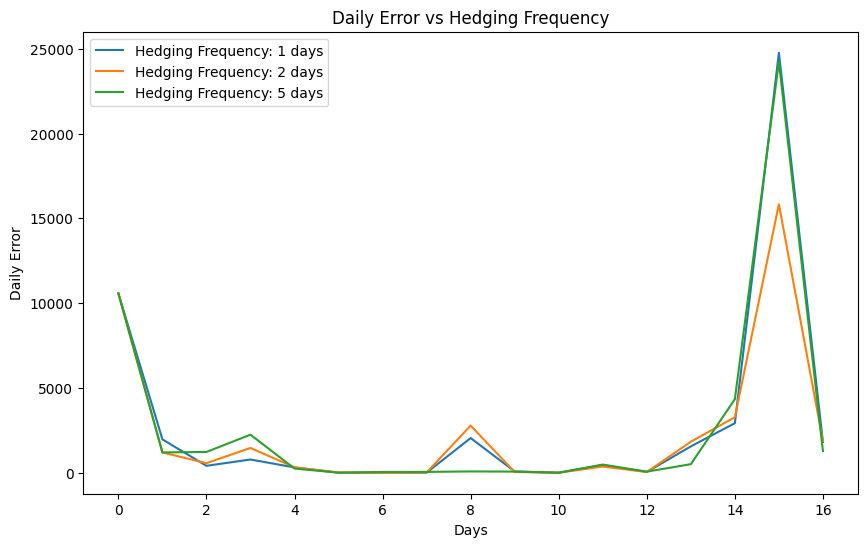

In [38]:
hedging_frequencies = [1, 2, 5]
plt.figure(figsize=(10, 6))
for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, freq, "P225")
    plt.plot(total_mean_squared_error, label=f'Hedging Frequency: {freq} days')

plt.xlabel('Days')
plt.ylabel('Daily Error')
plt.title('Daily Error vs Hedging Frequency')
plt.legend()
plt.show()

Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  68
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  67
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  55
The total mean squared error is :  4481.353105038685


Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  68
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  67
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  55
The total mean squared error is :  4481.353105038685


Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  68
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  67
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  55
The total mean squared error is :  4481.353105038685




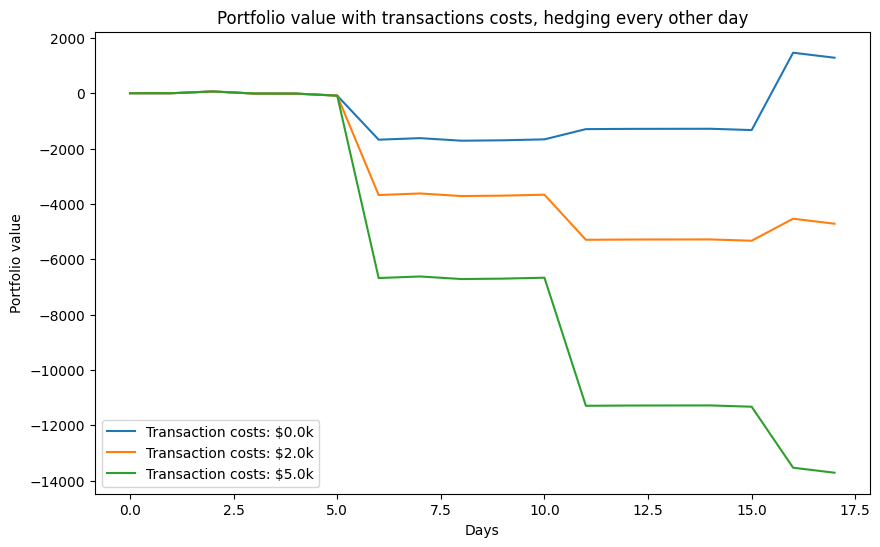

In [39]:
costs = [0.00, 0.02, 0.05]
plt.figure(figsize=(10, 6))
for c in costs:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, 5, "C225", costs=c) #every other day
    plt.plot(portfolio_values, label=f'Transaction costs: ${c*100}k') # change to % once done

plt.xlabel('Days')
plt.ylabel('Portfolio value')
plt.title('Portfolio value with transactions costs, hedging every other day')
plt.legend()
plt.show()


Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  59
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  65
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  70
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  66
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  68
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  73
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  75
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  76
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  65
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  64
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  66
Readjusting replicati

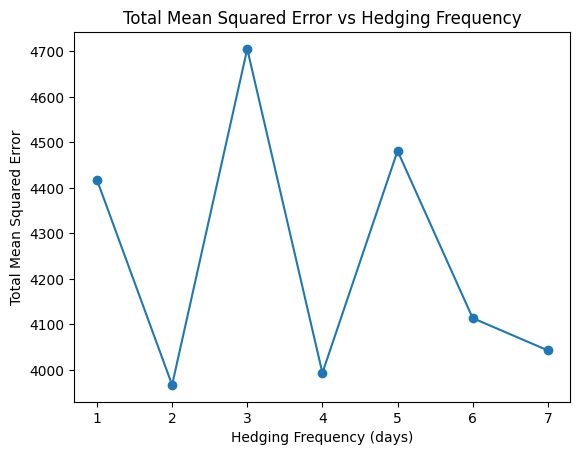

In [63]:
hedging_frequencies = [1, 2, 3, 4, 5, 6, 7]

results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, freq, "C225")
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

# Plotting
plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency')
plt.show()

Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  76
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  79
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  85
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  79
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  88
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  87
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  86
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  86
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  80
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  84
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  81
Readjusting replicati

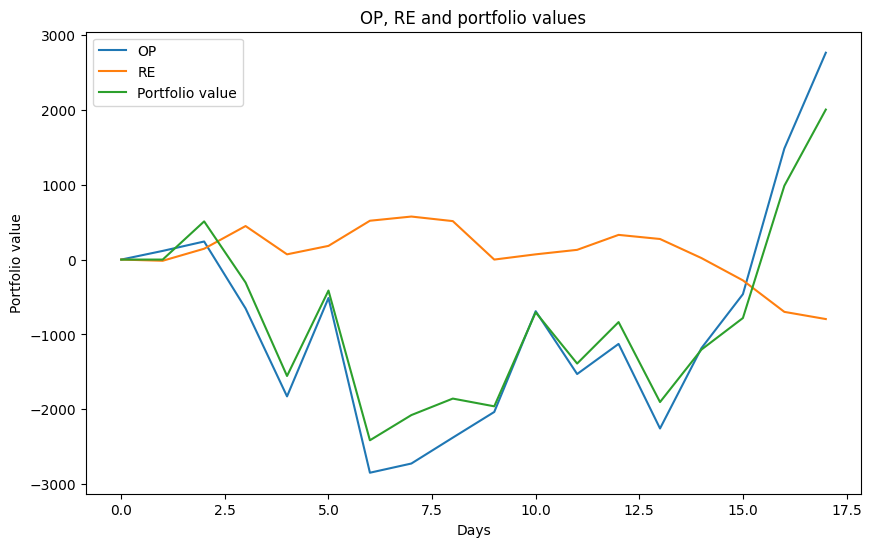

Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  82
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  83
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  91
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  86
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  81
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  87
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  79
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  69
The total mean squared error is :  10056.590759546669




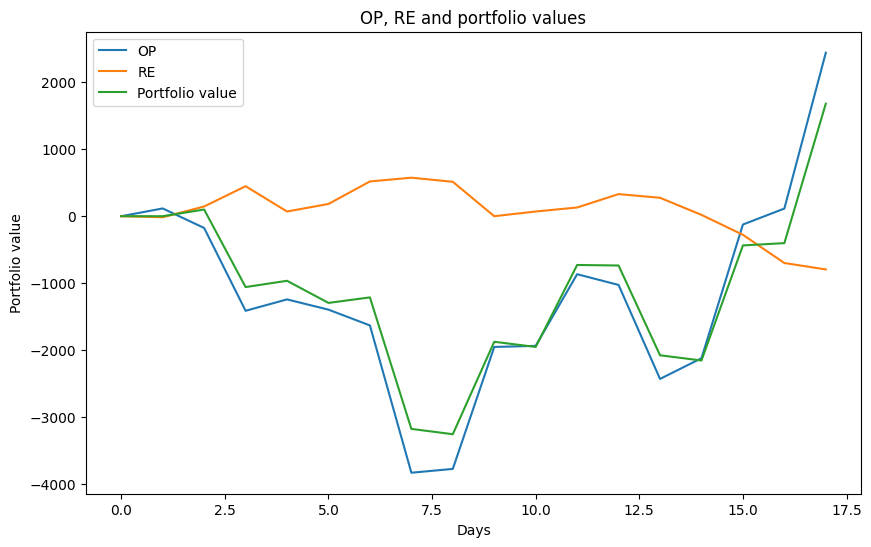

Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  85
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  85
Readjusting replicating portoflio RE, amount to short/sell to balance the portfolio:  79
The total mean squared error is :  10424.152168998573




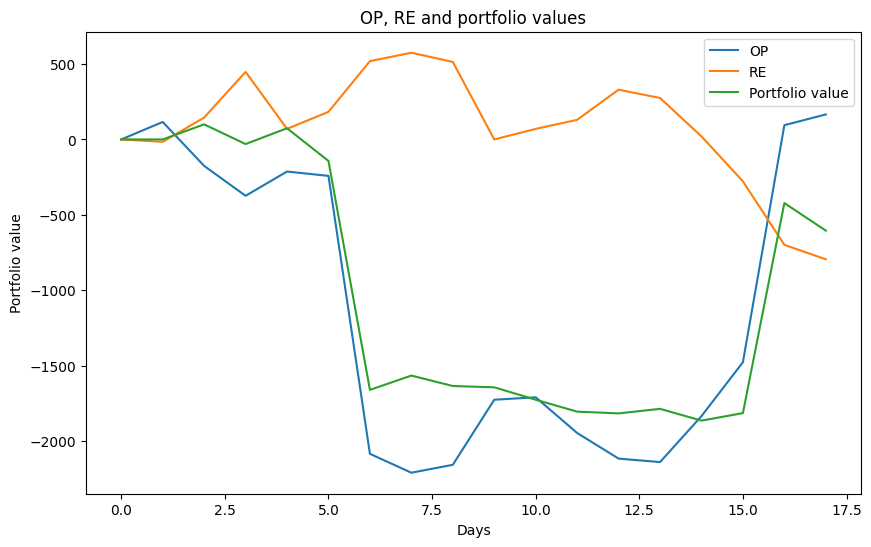

In [58]:
hedging_frequencies = [1, 2, 5]

for freq in hedging_frequencies:
    plt.figure(figsize=(10, 6))
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, freq, "C215")
    plt.plot(OPs, label=f'OP')
    plt.plot(REs, label=f'RE')
    plt.plot(portfolio_values, label=f'Portfolio value')
    
    plt.xlabel('Days')
    plt.ylabel('Portfolio value')
    plt.title('OP, RE and portfolio values')
    plt.legend()
    plt.show()

# Дельта хеджирование Straddle опциона

Стрэддл состоит из одного колл-опциона и одного пут-опциона с одинаковой ценой страйк и сроком истечения, на один и тот же базовый актив. 

In [59]:
def delta_hedge_straddle(option_prices, freq):
    option_amount = 100
    
    interest_rate = option_prices.iloc[0]['Interest rate'] 
    stock_price = option_prices.iloc[0]['Underlying']

    # Adjust here the call and put prices for your liking
    # STRADDLE = Same option with same strikes and maturity, put both call and put options
    call_option_price = option_prices.iloc[0]['C230']
    put_option_price = option_prices.iloc[0]['P230']
    strike = 230
    
    time_to_maturity = option_prices.iloc[0]['T']
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag='p')
    
    call_bsm = BSM(kind='call', S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=call_volatility)
    put_bsm = BSM(kind='put', S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=put_volatility)

    # Forming the straddle portfolio
    put_delta = put_bsm.delta()
    call_delta = call_bsm.delta()

    # Long position consists of both of the option values
    OP = call_bsm.value() * option_amount + put_bsm.value() * option_amount

    # Short position, the replicating portfolio, consists of the call and put delta amounts of the underlying 
    RE = - (call_delta * stock_price * option_amount + put_delta * stock_price * option_amount)

    # Combined delta of the options
    combined_delta = call_delta + put_delta

    # Keep track of the mean squared error values, which means changes in the portfolios
    total_mean_squared_error = []
    
    # total transaction costs carry and decrease the value of portfolio
    transact_costs = 0
    
    # add initial portfolio value to the list
    portfolio_values = [OP+RE]

    OPs = [OP]
    REs = [RE]
    
    # Calculate changes in OP and RE and let A_0 = d OP + d RE
    for i in range(1, len(option_prices)-1):
        new_call_bsm_obj = BSM(kind='call', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility)
        new_put_bsm_obj = BSM(kind='put', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility)
        new_OP = new_call_bsm_obj.value() * option_amount + new_put_bsm_obj.value() * option_amount
        new_RE = -combined_delta * option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE
        a_0 = d_OP + d_RE
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP+RE+transact_costs)
        OPs.append(new_OP)
        REs.append(new_RE)
        OP = new_OP
        RE = new_RE

        if i % freq == 0:
            put_delta = new_put_bsm_obj.delta()
            call_delta= new_call_bsm_obj.delta()
            combined_delta =  put_delta + call_delta
            call_volatility = BSM(kind='call', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility).implied_vol(option_prices['C230'][i])
            put_volatility = BSM(kind='put', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility).implied_vol(option_prices['P230'][i])

            RE = -combined_delta * option_prices['Underlying'][i] * option_amount
            
            amount = -(combined_delta * option_amount)
            if amount > 0:
                print('Readjusting replicating portoflio RE, amount options to buy to balance the portfolio: ', round(amount))
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio: ', round(-amount))
            else:
                print('Portfolio is in balance, no need for readjustment')

    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1]
    total_error *= (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)
    print("\n")

    portfolio_values -= portfolio_values[0]
    REs -= REs[0]
    OPs -= OPs[0]
    
    return total_mean_squared_error, total_error, portfolio_values, REs, OPs

Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  2
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  13
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  23
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  14
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  16
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  28
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  34
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  32
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  9
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  8
Readjusting replicating portoflio RE, am

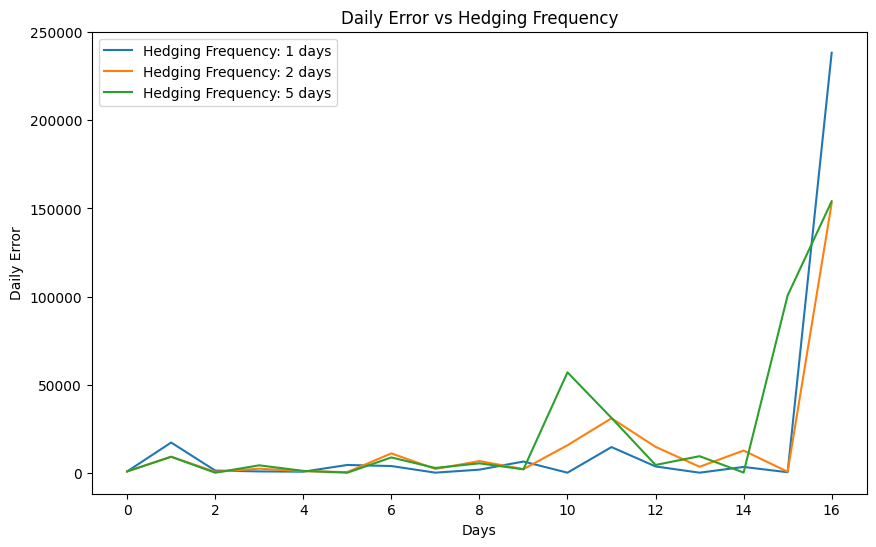

In [60]:
hedging_frequencies = [1, 2, 5]
plt.figure(figsize=(10, 6))
for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge_straddle(df_result, freq)
    plt.plot(total_mean_squared_error, label=f'Hedging Frequency: {freq} days')

plt.xlabel('Days')
plt.ylabel('Daily Error')
plt.title('Daily Error vs Hedging Frequency')
plt.legend()
plt.show()


Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  2
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  13
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  23
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  14
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  16
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  28
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  34
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  32
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  9
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  8
Readjusting replicating portoflio RE, am

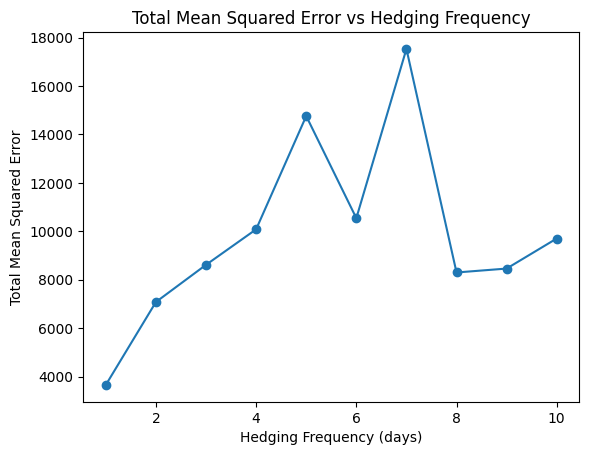

In [61]:
hedging_frequencies = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge_straddle(df_result, freq)
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency')
plt.show()

Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  2
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  13
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  23
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  14
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  16
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  28
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  34
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  32
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  9
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  8
Readjusting replicating portoflio RE, am

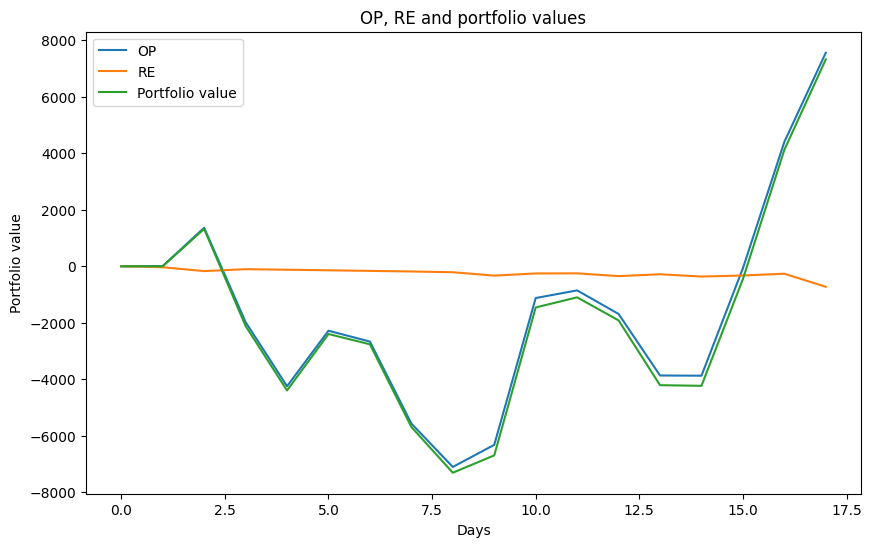

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  13
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  14
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  27
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  32
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  8
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  22
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  5
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  32
The total mean squared error is :  7079.842398788942




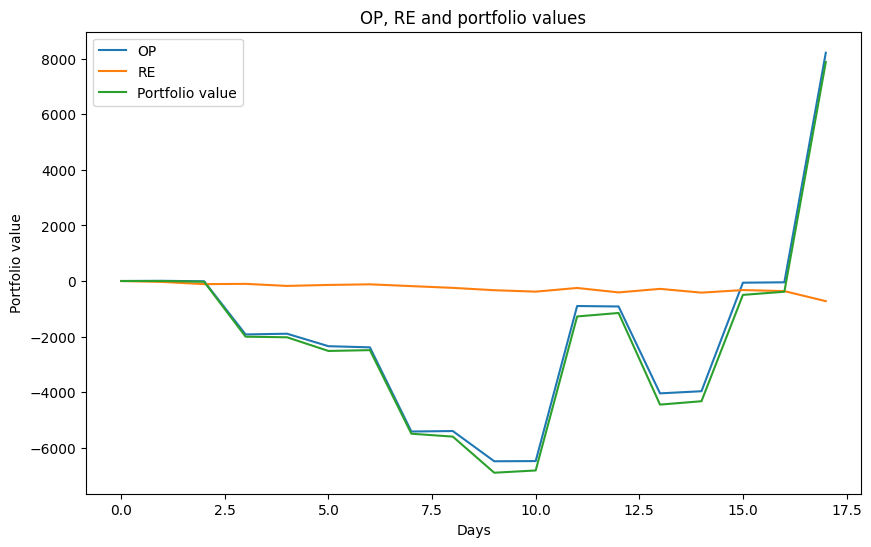

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  16
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  9
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  22
The total mean squared error is :  14760.916794352132




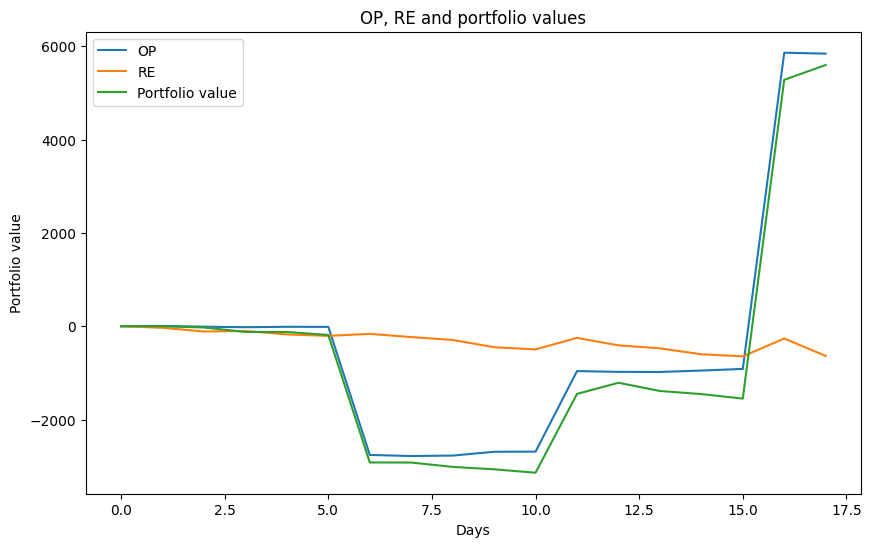

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  36
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  5
The total mean squared error is :  17534.227660935103




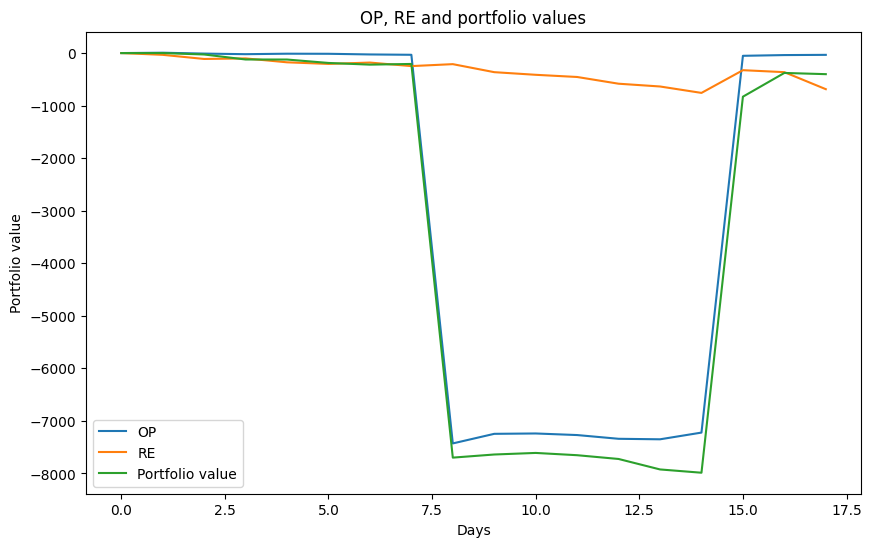

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  9
The total mean squared error is :  9702.79556980679




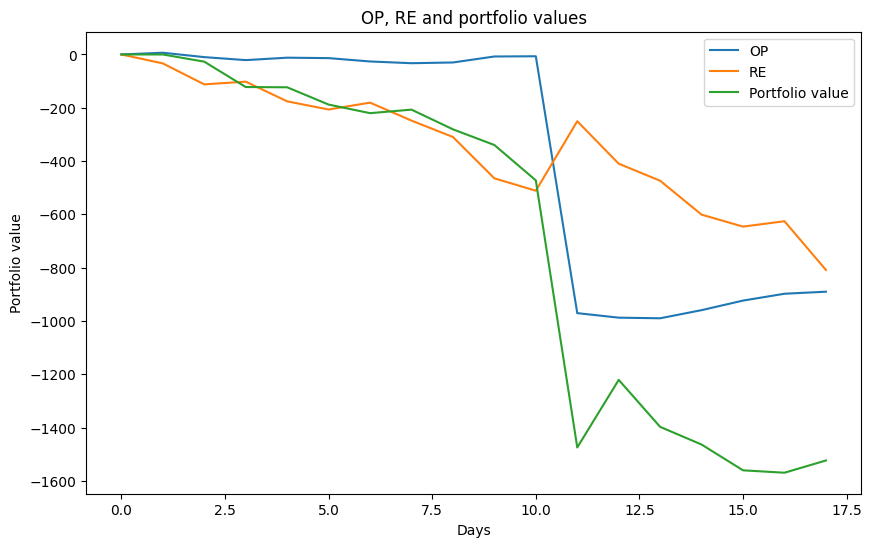

In [62]:
hedging_frequencies = [1, 2, 5, 7, 10]

for freq in hedging_frequencies:
    plt.figure(figsize=(10, 6))
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge_straddle(df_result, freq)
    plt.plot(OPs, label=f'OP')
    plt.plot(REs, label=f'RE')
    plt.plot(portfolio_values, label=f'Portfolio value')
    
    plt.xlabel('Days')
    plt.ylabel('Portfolio value')
    plt.title('OP, RE and portfolio values')
    plt.legend()
    plt.show()

## Выводы

* Видим что дельта хеджирование портфеля из одного опциона, **уменьшает волатильность стоимости портфеля**, однако использование implied волатильности, вместо оценки справедливой волатильности (какое либо предсказание) уменьшает эффективность хеджа.

* Более частые балансировки приводят к лучшим результатам, однако это верно лишь при низкой волатильности implied volatility в рынке (что верно для AAPL на этом периоде)

